## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 11446401.98it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169484.75it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3207687.83it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6701513.65it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
from sklearn.model_selection import train_test_split

In [5]:
fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, test_size=0.1)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_val,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [9]:
from torchvision.utils import make_grid

def show_images(img, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img.detach().cpu()[:nmax], nrow=8).permute(1, 2, 0))
    plt.show()

torch.Size([128, 1, 28, 28])


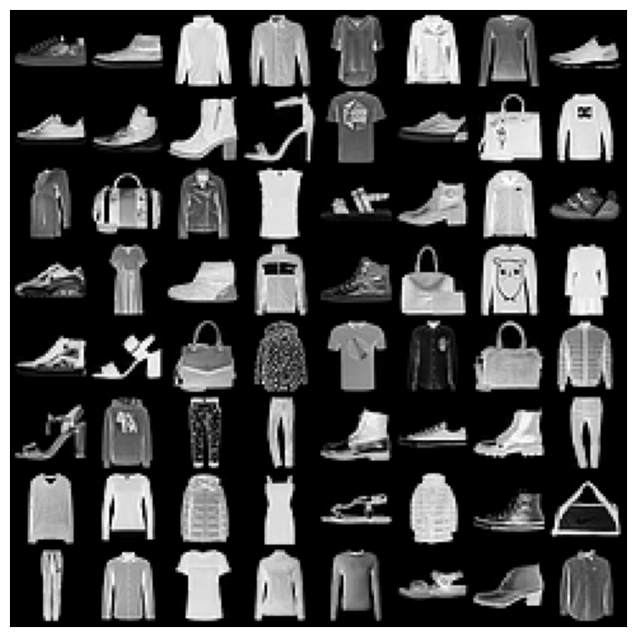

In [10]:
for img, label in train_loader:
    print(img.shape)
    show_images(img)
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [11]:
import torch.nn.functional as F

class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)

        return F.softmax(out)

In [12]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
              ReLU-7                 [-1, 4096]               0
            Linear-8                   [-1, 10]          40,970
Total params: 36,818,954
Trainable params: 36,818,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 140.45
Estimated Total Size (MB): 140.65
----------------------------------------------------------------


<ipython-input-11-ef590e0243b3>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


Your experiments come here:

In [13]:
def get_accuracy_score(model, data_loader):
    model.eval()

    correct = 0
    processed_size = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            y_pred = model.forward(x_batch)
            preds = torch.argmax(y_pred, axis=1)
            correct += torch.sum(preds == y_batch)
            processed_size += len(x_batch)

    return correct / processed_size

In [14]:
def fit_epoch(model, optimizer, train_loader, criterion):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for X, y in train_loader:
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_size += len(X)

    return running_loss / processed_size

In [15]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    processed_size = 0

    with torch.no_grad():
        for X, y in val_loader:
            preds = model(X)
            loss = criterion(preds, y, reduction='sum')

            running_loss += loss.item()
            processed_size += len(X)

    return running_loss / processed_size

In [16]:
from tqdm import tqdm

def train(model, optimizer, train_loader, val_loader, criterion, epochs, scheduler=None):
    loss_history = []
    score_history = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss = fit_epoch(model, optimizer, train_loader, criterion)
            val_loss = eval_epoch(model, val_loader, criterion)
            loss_history.append((train_loss, val_loss))
            print(f"Train loss: {train_loss}, val loss: {val_loss}")

            train_score = get_accuracy_score(model, train_loader)
            val_score = get_accuracy_score(model, val_loader)
            score_history.append((train_score, val_score))
            print(f"Train score: {train_score}, val score: {val_score}")

            if scheduler is not None:
                scheduler.step()

            pbar.update(1)

    return loss_history, score_history

In [17]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_func = F.cross_entropy
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=40, gamma=0.1)

loss_history, score_history = train(model, opt, train_loader, val_loader, loss_func, 100, scheduler)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-11-ef590e0243b3>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


Train loss: 0.013276640415191651, val loss: 1.654692626953125


  1%|          | 1/100 [00:13<21:49, 13.23s/it]

Train score: 0.8059999942779541, val score: 0.8076666593551636
Train loss: 0.012698641041914621, val loss: 1.6147206802368164


  2%|▏         | 2/100 [00:24<19:24, 11.88s/it]

Train score: 0.8418332934379578, val score: 0.847000002861023
Train loss: 0.012569256998874522, val loss: 1.6125253117879232


  3%|▎         | 3/100 [00:37<20:25, 12.64s/it]

Train score: 0.8419629335403442, val score: 0.8488333225250244
Train loss: 0.012494834553312371, val loss: 1.5912535909016927


  4%|▍         | 4/100 [00:48<19:21, 12.10s/it]

Train score: 0.8710925579071045, val score: 0.8703333139419556
Train loss: 0.012428029051533451, val loss: 1.5989843292236328


  5%|▌         | 5/100 [00:59<18:31, 11.70s/it]

Train score: 0.8622221946716309, val score: 0.8623332977294922
Train loss: 0.01240434221426646, val loss: 1.5843435719807943


  6%|▌         | 6/100 [01:10<17:53, 11.41s/it]

Train score: 0.878166675567627, val score: 0.8766666650772095
Train loss: 0.012381912573620125, val loss: 1.5806977920532226


  7%|▋         | 7/100 [01:21<17:21, 11.20s/it]

Train score: 0.8836851716041565, val score: 0.8806666731834412
Train loss: 0.012347226950857375, val loss: 1.5921250940958658


  8%|▊         | 8/100 [01:32<17:11, 11.21s/it]

Train score: 0.8801110982894897, val score: 0.8683333396911621
Train loss: 0.012331678339728603, val loss: 1.5792973429361978


  9%|▉         | 9/100 [01:43<16:48, 11.08s/it]

Train score: 0.8862037062644958, val score: 0.8828333020210266
Train loss: 0.012300300949149662, val loss: 1.5848387603759766


 10%|█         | 10/100 [01:55<16:53, 11.26s/it]

Train score: 0.8789073824882507, val score: 0.8763332962989807
Train loss: 0.012308881209956275, val loss: 1.5833558781941732


 11%|█         | 11/100 [02:06<16:29, 11.12s/it]

Train score: 0.8839259147644043, val score: 0.8773333430290222
Train loss: 0.012296321517891354, val loss: 1.572127596537272


 12%|█▏        | 12/100 [02:16<16:08, 11.01s/it]

Train score: 0.8953888416290283, val score: 0.8891666531562805
Train loss: 0.012284787758632943, val loss: 1.5893475748697916


 13%|█▎        | 13/100 [02:28<16:02, 11.07s/it]

Train score: 0.8760185241699219, val score: 0.8711666464805603
Train loss: 0.01225543404287762, val loss: 1.584569132486979


 14%|█▍        | 14/100 [02:38<15:47, 11.02s/it]

Train score: 0.8857036828994751, val score: 0.8761666417121887
Train loss: 0.012267153903290078, val loss: 1.5693989537556967


 15%|█▌        | 15/100 [02:49<15:30, 10.95s/it]

Train score: 0.8984629511833191, val score: 0.8916666507720947
Train loss: 0.012252372022028323, val loss: 1.5805389353434245


 16%|█▌        | 16/100 [03:00<15:14, 10.89s/it]

Train score: 0.8875370025634766, val score: 0.8801666498184204
Train loss: 0.012235163010932781, val loss: 1.57543465423584


 17%|█▋        | 17/100 [03:11<15:00, 10.85s/it]

Train score: 0.8954814672470093, val score: 0.8858333230018616
Train loss: 0.012222593894711246, val loss: 1.5678384679158528


 18%|█▊        | 18/100 [03:22<15:00, 10.99s/it]

Train score: 0.9029629230499268, val score: 0.8928333520889282
Train loss: 0.012211925976806216, val loss: 1.5687018025716146


 19%|█▉        | 19/100 [03:33<14:42, 10.90s/it]

Train score: 0.9030555486679077, val score: 0.8921666741371155
Train loss: 0.012215344104501936, val loss: 1.5679605865478516


 20%|██        | 20/100 [03:44<14:30, 10.88s/it]

Train score: 0.9067962765693665, val score: 0.8928333520889282
Train loss: 0.012208266582753924, val loss: 1.5650775604248046


 21%|██        | 21/100 [03:54<14:16, 10.84s/it]

Train score: 0.9083333015441895, val score: 0.8963333368301392
Train loss: 0.012181372476948633, val loss: 1.5707033487955728


 22%|██▏       | 22/100 [04:05<14:09, 10.89s/it]

Train score: 0.9040740728378296, val score: 0.8901666402816772
Train loss: 0.012198845717642043, val loss: 1.568174171447754


 23%|██▎       | 23/100 [04:17<14:07, 11.01s/it]

Train score: 0.9069444537162781, val score: 0.8921666741371155
Train loss: 0.012194382482104832, val loss: 1.5800543950398762


 24%|██▍       | 24/100 [04:27<13:48, 10.90s/it]

Train score: 0.9001110792160034, val score: 0.8794999718666077
Train loss: 0.012188232212154954, val loss: 1.5690537567138672


 25%|██▌       | 25/100 [04:38<13:36, 10.88s/it]

Train score: 0.9052592515945435, val score: 0.890999972820282
Train loss: 0.012198032935460408, val loss: 1.5713317082722982


 26%|██▌       | 26/100 [04:49<13:22, 10.84s/it]

Train score: 0.9054073691368103, val score: 0.8893333077430725
Train loss: 0.012190625254754667, val loss: 1.5690781021118163


 27%|██▋       | 27/100 [05:00<13:16, 10.91s/it]

Train score: 0.9043888449668884, val score: 0.8926666378974915
Train loss: 0.012173486731670522, val loss: 1.5757533874511718


 28%|██▊       | 28/100 [05:11<13:11, 11.00s/it]

Train score: 0.8994444012641907, val score: 0.8848333358764648
Train loss: 0.01218123616995635, val loss: 1.5686188837687174


 29%|██▉       | 29/100 [05:22<12:56, 10.93s/it]

Train score: 0.9042962789535522, val score: 0.8923333287239075
Train loss: 0.012194673282128794, val loss: 1.5670087407430013


 30%|███       | 30/100 [05:33<12:43, 10.91s/it]

Train score: 0.9073333144187927, val score: 0.893666684627533
Train loss: 0.012180464091124358, val loss: 1.5800190404256185


 31%|███       | 31/100 [05:44<12:43, 11.07s/it]

Train score: 0.89340740442276, val score: 0.8808333277702332
Train loss: 0.012177396736763142, val loss: 1.5753035685221355


 32%|███▏      | 32/100 [05:55<12:36, 11.13s/it]

Train score: 0.8978148102760315, val score: 0.8856666684150696
Train loss: 0.012162116406140504, val loss: 1.5679511947631837


 33%|███▎      | 33/100 [06:06<12:18, 11.02s/it]

Train score: 0.9087777733802795, val score: 0.8928333520889282
Train loss: 0.012168730384773679, val loss: 1.5714325434366863


 34%|███▍      | 34/100 [06:17<12:03, 10.97s/it]

Train score: 0.907444417476654, val score: 0.8886666297912598
Train loss: 0.01215623590239772, val loss: 1.5680080235799154


 35%|███▌      | 35/100 [06:28<11:50, 10.94s/it]

Train score: 0.9087777733802795, val score: 0.8939999938011169
Train loss: 0.012156495476210559, val loss: 1.570765251159668


 36%|███▌      | 36/100 [06:39<11:38, 10.92s/it]

Train score: 0.9075185060501099, val score: 0.890500009059906
Train loss: 0.012177339447869195, val loss: 1.5730693028767904


 37%|███▋      | 37/100 [06:50<11:34, 11.02s/it]

Train score: 0.9012036919593811, val score: 0.887833297252655
Train loss: 0.012173745894873583, val loss: 1.578932139078776


 38%|███▊      | 38/100 [07:01<11:16, 10.91s/it]

Train score: 0.8989444375038147, val score: 0.8818333148956299
Train loss: 0.012165740573847736, val loss: 1.5749232432047526


 39%|███▉      | 39/100 [07:12<11:03, 10.88s/it]

Train score: 0.9030740261077881, val score: 0.8858333230018616
Train loss: 0.012155128320058188, val loss: 1.5767622680664062


 40%|████      | 40/100 [07:22<10:49, 10.83s/it]

Train score: 0.9029814600944519, val score: 0.8840000033378601
Train loss: 0.012072056843174828, val loss: 1.5612370249430338


 41%|████      | 41/100 [07:33<10:44, 10.93s/it]

Train score: 0.920962929725647, val score: 0.8995000123977661
Train loss: 0.012030815846390194, val loss: 1.5598321126302084


 42%|████▏     | 42/100 [07:45<10:40, 11.04s/it]

Train score: 0.924648106098175, val score: 0.9013333320617676
Train loss: 0.012003932526818029, val loss: 1.5610172653198242


 43%|████▎     | 43/100 [07:55<10:23, 10.93s/it]

Train score: 0.9257962703704834, val score: 0.8993332982063293
Train loss: 0.011994124586935396, val loss: 1.5570662434895832


 44%|████▍     | 44/100 [08:06<10:09, 10.88s/it]

Train score: 0.9281851649284363, val score: 0.9038333296775818
Train loss: 0.011985951244831086, val loss: 1.5572569885253906


 45%|████▌     | 45/100 [08:17<09:56, 10.84s/it]

Train score: 0.9286666512489319, val score: 0.903166651725769
Train loss: 0.011980338169468774, val loss: 1.5571032282511392


 46%|████▌     | 46/100 [08:28<09:50, 10.94s/it]

Train score: 0.9287962913513184, val score: 0.903333306312561
Train loss: 0.01197101902961731, val loss: 1.5564115600585937


 47%|████▋     | 47/100 [08:39<09:39, 10.93s/it]

Train score: 0.9309444427490234, val score: 0.9043333530426025
Train loss: 0.011965882764922248, val loss: 1.55674351755778


 48%|████▊     | 48/100 [08:50<09:25, 10.88s/it]

Train score: 0.9319074153900146, val score: 0.9036666750907898
Train loss: 0.011959589618223685, val loss: 1.5568998540242514


 49%|████▉     | 49/100 [09:01<09:13, 10.85s/it]

Train score: 0.9317777752876282, val score: 0.903499960899353
Train loss: 0.01195403082061697, val loss: 1.554929189046224


 50%|█████     | 50/100 [09:11<09:00, 10.81s/it]

Train score: 0.93235182762146, val score: 0.906000018119812
Train loss: 0.011951551126109228, val loss: 1.555930076599121


 51%|█████     | 51/100 [09:23<08:57, 10.96s/it]

Train score: 0.9336296319961548, val score: 0.9054999947547913
Train loss: 0.011942896710501777, val loss: 1.5557699712117512


 52%|█████▏    | 52/100 [09:33<08:43, 10.91s/it]

Train score: 0.9340925812721252, val score: 0.9051666855812073
Train loss: 0.011939652036737513, val loss: 1.5553779042561848


 53%|█████▎    | 53/100 [09:44<08:31, 10.88s/it]

Train score: 0.9347037076950073, val score: 0.906000018119812
Train loss: 0.011930583430661095, val loss: 1.5564818216959635


 54%|█████▍    | 54/100 [09:55<08:18, 10.83s/it]

Train score: 0.9350370168685913, val score: 0.9045000076293945
Train loss: 0.011929853295838391, val loss: 1.5537621409098308


 55%|█████▌    | 55/100 [10:06<08:06, 10.82s/it]

Train score: 0.9357221722602844, val score: 0.9076666831970215
Train loss: 0.011926590416166517, val loss: 1.5546731236775717


 56%|█████▌    | 56/100 [10:17<08:02, 10.97s/it]

Train score: 0.936629593372345, val score: 0.90666663646698
Train loss: 0.011919321636358896, val loss: 1.5554751256306967


 57%|█████▋    | 57/100 [10:29<08:00, 11.17s/it]

Train score: 0.9368518590927124, val score: 0.9051666855812073
Train loss: 0.011917273181456106, val loss: 1.5540503718058267


 58%|█████▊    | 58/100 [10:39<07:45, 11.08s/it]

Train score: 0.9373332858085632, val score: 0.9068333506584167
Train loss: 0.011913020036838673, val loss: 1.5549631703694662


 59%|█████▉    | 59/100 [10:50<07:29, 10.96s/it]

Train score: 0.9374444484710693, val score: 0.906166672706604
Train loss: 0.011911789103790565, val loss: 1.5540384826660156


 60%|██████    | 60/100 [11:01<07:19, 10.99s/it]

Train score: 0.9382962584495544, val score: 0.9073333144187927
Train loss: 0.011905344550256375, val loss: 1.55516286722819


 61%|██████    | 61/100 [11:12<07:09, 11.02s/it]

Train score: 0.9380740523338318, val score: 0.9048333168029785
Train loss: 0.011902389272495551, val loss: 1.5543119099934897


 62%|██████▏   | 62/100 [11:23<06:56, 10.95s/it]

Train score: 0.9387221932411194, val score: 0.906333327293396
Train loss: 0.011903370671802097, val loss: 1.5551325225830077


 63%|██████▎   | 63/100 [11:34<06:43, 10.92s/it]

Train score: 0.9387962818145752, val score: 0.9054999947547913
Train loss: 0.011900738166438208, val loss: 1.5551091918945312


 64%|██████▍   | 64/100 [11:45<06:31, 10.88s/it]

Train score: 0.9393518567085266, val score: 0.9058333039283752
Train loss: 0.011895998848809135, val loss: 1.5561262995402019


 65%|██████▌   | 65/100 [11:56<06:22, 10.94s/it]

Train score: 0.9394444227218628, val score: 0.9045000076293945
Train loss: 0.011895226173930698, val loss: 1.5548814697265625


 66%|██████▌   | 66/100 [12:07<06:11, 10.92s/it]

Train score: 0.9400925636291504, val score: 0.906166672706604
Train loss: 0.0118916865211946, val loss: 1.554854990641276


 67%|██████▋   | 67/100 [12:17<05:58, 10.88s/it]

Train score: 0.9404629468917847, val score: 0.9056666493415833
Train loss: 0.011890397987983845, val loss: 1.5556512807210285


 68%|██████▊   | 68/100 [12:28<05:47, 10.86s/it]

Train score: 0.9407592415809631, val score: 0.9046666622161865
Train loss: 0.011892659430150632, val loss: 1.555245206197103


 69%|██████▉   | 69/100 [12:39<05:36, 10.85s/it]

Train score: 0.9402592182159424, val score: 0.906166672706604
Train loss: 0.011886511005737163, val loss: 1.5565635604858399


 70%|███████   | 70/100 [12:50<05:30, 11.01s/it]

Train score: 0.939370334148407, val score: 0.9043333530426025
Train loss: 0.011884295403957367, val loss: 1.5556390279134114


 71%|███████   | 71/100 [13:01<05:18, 10.97s/it]

Train score: 0.9415000081062317, val score: 0.9045000076293945
Train loss: 0.01188097608310205, val loss: 1.5557330881754556


 72%|███████▏  | 72/100 [13:12<05:06, 10.95s/it]

Train score: 0.9415925741195679, val score: 0.9046666622161865
Train loss: 0.01187822546782317, val loss: 1.555884661356608


 73%|███████▎  | 73/100 [13:23<04:54, 10.90s/it]

Train score: 0.9415370225906372, val score: 0.9046666622161865
Train loss: 0.011878398301424804, val loss: 1.5559385833740234


 74%|███████▍  | 74/100 [13:34<04:43, 10.92s/it]

Train score: 0.9419629573822021, val score: 0.9051666855812073
Train loss: 0.01187981594050372, val loss: 1.5560416107177735


 75%|███████▌  | 75/100 [13:45<04:35, 11.03s/it]

Train score: 0.9402222037315369, val score: 0.9046666622161865
Train loss: 0.011876048975520664, val loss: 1.5556108881632487


 76%|███████▌  | 76/100 [13:56<04:22, 10.93s/it]

Train score: 0.9426481127738953, val score: 0.9046666622161865
Train loss: 0.011871233701705933, val loss: 1.5544990921020507


 77%|███████▋  | 77/100 [14:07<04:10, 10.91s/it]

Train score: 0.9426851868629456, val score: 0.90666663646698
Train loss: 0.011870352195368873, val loss: 1.555875249226888


 78%|███████▊  | 78/100 [14:18<03:59, 10.88s/it]

Train score: 0.942981481552124, val score: 0.9049999713897705
Train loss: 0.01186890854217388, val loss: 1.5547129821777343


 79%|███████▉  | 79/100 [14:29<03:49, 10.94s/it]

Train score: 0.9430184960365295, val score: 0.906499981880188
Train loss: 0.011865957807611537, val loss: 1.556121877034505


 80%|████████  | 80/100 [14:40<03:40, 11.04s/it]

Train score: 0.9434444308280945, val score: 0.9051666855812073
Train loss: 0.011860200645747008, val loss: 1.5557141138712565


 81%|████████  | 81/100 [14:51<03:27, 10.93s/it]

Train score: 0.9438148140907288, val score: 0.906000018119812
Train loss: 0.011858459737565783, val loss: 1.5561401011149087


 82%|████████▏ | 82/100 [15:02<03:16, 10.89s/it]

Train score: 0.9439073801040649, val score: 0.9048333168029785
Train loss: 0.011857612612070861, val loss: 1.556311429341634


 83%|████████▎ | 83/100 [15:12<03:05, 10.91s/it]

Train score: 0.9440184831619263, val score: 0.9039999842643738
Train loss: 0.011856806931672273, val loss: 1.5564685338338216


 84%|████████▍ | 84/100 [15:24<02:56, 11.03s/it]

Train score: 0.9440925717353821, val score: 0.9045000076293945
Train loss: 0.011856182069690139, val loss: 1.5565487798055013


 85%|████████▌ | 85/100 [15:35<02:46, 11.10s/it]

Train score: 0.9441666603088379, val score: 0.9041666388511658
Train loss: 0.011855910903877682, val loss: 1.556420878092448


 86%|████████▌ | 86/100 [15:46<02:33, 10.98s/it]

Train score: 0.9442222118377686, val score: 0.9041666388511658
Train loss: 0.011855347549473799, val loss: 1.556646011352539


 87%|████████▋ | 87/100 [15:57<02:22, 10.95s/it]

Train score: 0.9443147778511047, val score: 0.9039999842643738
Train loss: 0.011854898225378108, val loss: 1.556321393330892


 88%|████████▊ | 88/100 [16:07<02:11, 10.92s/it]

Train score: 0.944351851940155, val score: 0.9043333530426025
Train loss: 0.011854506293932596, val loss: 1.5562573013305665


 89%|████████▉ | 89/100 [16:19<02:00, 11.00s/it]

Train score: 0.9443703293800354, val score: 0.9046666622161865
Train loss: 0.011854124901471315, val loss: 1.5562861455281576


 90%|█████████ | 90/100 [16:30<01:50, 11.04s/it]

Train score: 0.9443888664245605, val score: 0.9043333530426025
Train loss: 0.011853813546675224, val loss: 1.5561280008951823


 91%|█████████ | 91/100 [16:41<01:38, 10.96s/it]

Train score: 0.9444258809089661, val score: 0.9046666622161865
Train loss: 0.011853698937981216, val loss: 1.5562186330159504


 92%|█████████▏| 92/100 [16:51<01:27, 10.91s/it]

Train score: 0.9444258809089661, val score: 0.9051666855812073
Train loss: 0.01185347055947339, val loss: 1.5560478515625


 93%|█████████▎| 93/100 [17:02<01:16, 10.86s/it]

Train score: 0.9444444179534912, val score: 0.9049999713897705
Train loss: 0.011853230050316563, val loss: 1.5563323491414387


 94%|█████████▍| 94/100 [17:13<01:05, 10.94s/it]

Train score: 0.9444814324378967, val score: 0.9046666622161865
Train loss: 0.011852969683982709, val loss: 1.5563433202107748


 95%|█████████▌| 95/100 [17:24<00:54, 10.92s/it]

Train score: 0.9444814324378967, val score: 0.9046666622161865
Train loss: 0.011852763723444055, val loss: 1.5560573857625326


 96%|█████████▌| 96/100 [17:35<00:43, 10.89s/it]

Train score: 0.9444814324378967, val score: 0.9051666855812073
Train loss: 0.011852665287476999, val loss: 1.55616566212972


 97%|█████████▋| 97/100 [17:46<00:32, 10.87s/it]

Train score: 0.9444999694824219, val score: 0.9046666622161865
Train loss: 0.011852431798422778, val loss: 1.556259386698405


 98%|█████████▊| 98/100 [17:56<00:21, 10.83s/it]

Train score: 0.9445370435714722, val score: 0.9046666622161865
Train loss: 0.01185215676051599, val loss: 1.5561924896240233


 99%|█████████▉| 99/100 [18:08<00:10, 10.96s/it]

Train score: 0.9445740580558777, val score: 0.9046666622161865
Train loss: 0.011851896614940079, val loss: 1.5560156504313152


100%|██████████| 100/100 [18:19<00:00, 10.99s/it]

Train score: 0.9446110725402832, val score: 0.9045000076293945


In [30]:
import seaborn as sns

def handle_history(loss_history, score_history):
    sns.set(style="whitegrid", font_scale=1.4)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
    plt.tight_layout()
    plt.subplots_adjust(top=1.5, right=1.5)

    tr_loss = np.array(loss_history)[:, 0]
    val_loss = np.array(loss_history)[:, 1]

    tr_score = torch.Tensor(score_history)[:, 0]
    val_score = torch.Tensor(score_history)[:, 1]

    val_argmax = torch.argmax(val_score)
    tr_y = tr_score[val_argmax]

    ax[0][0].axhline(y = val_score[val_argmax], color = 'r', linestyle = '-')
    ax[0][0].axhline(y = tr_y, color = 'r', linestyle = '-')

    ax[0][0].plot(tr_score, label='train')
    ax[0][0].plot(val_score, label='val')
    ax[0][0].set_ylabel('Score')
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].legend()

    ax[0][1].remove()

    ax[1][0].plot(tr_loss)
    ax[1][0].set_title('Train')
    ax[1][0].set_ylabel('Loss')
    ax[1][0].set_xlabel('Epoch')
    ax[1][0].legend()
    ax[1][0].set_yscale('log')


    ax[1][1].plot(val_loss)
    ax[1][1].set_title('Validation')
    ax[1][1].set_ylabel('Loss')
    ax[1][1].set_xlabel('Epoch')
    ax[1][1].legend()
    ax[1][1].set_yscale('log')

    plt.show()

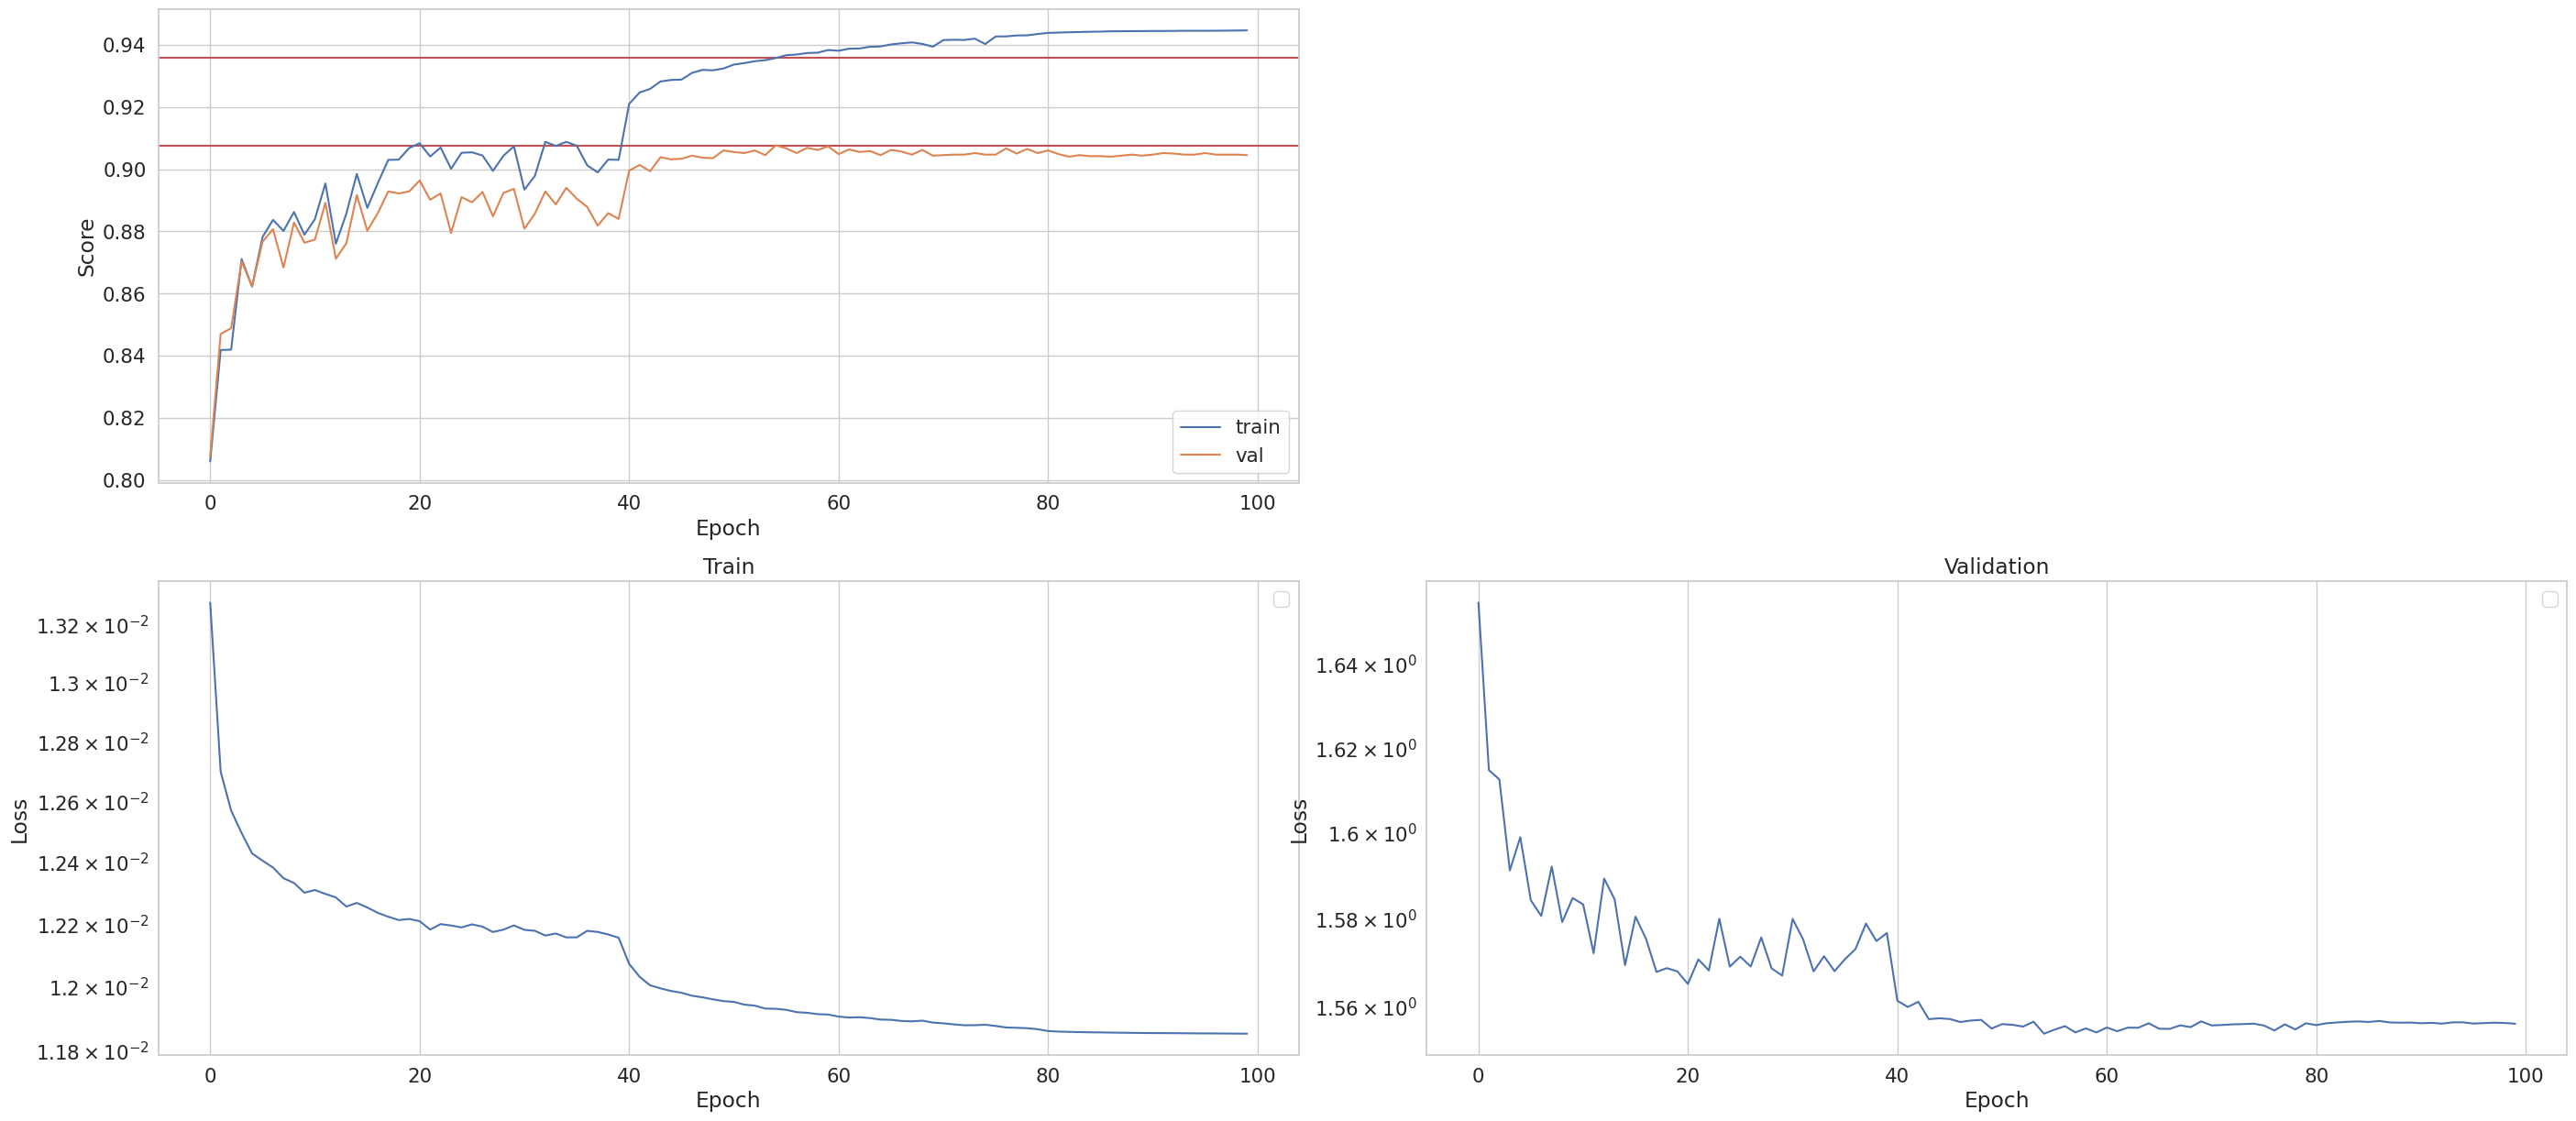

In [31]:
handle_history(loss_history, score_history)

In [32]:
accuracy = get_accuracy_score(model, test_loader)
print(f"accuracy: {accuracy}")

<ipython-input-11-ef590e0243b3>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


accuracy: 0.8955000042915344


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Понятие переобучения относительно. Модель выше уже переобучается. В определённый момент accuracy на валидации вообще перестаёт расти в отличие от скора на трейне (см. красные линии). Поэтому логично предположить, что модель действительно переобучилась. Добавим в неё дропауты:

In [33]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)

        return F.softmax(out)

In [34]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              ReLU-6                 [-1, 4096]               0
           Dropout-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
          Dropout-10                 [-1, 4096]               0
           Linear-11                   [-1, 10]          40,970
Total params: 36,818,954
Trainable params: 36,818,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

<ipython-input-33-ff99a27b8c7c>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


In [35]:
fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [36]:
fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, test_size=0.5)

In [37]:
fmnist_dataset_train = fmnist_dataset_train[:10000]

torch.Size([128, 1, 28, 28])


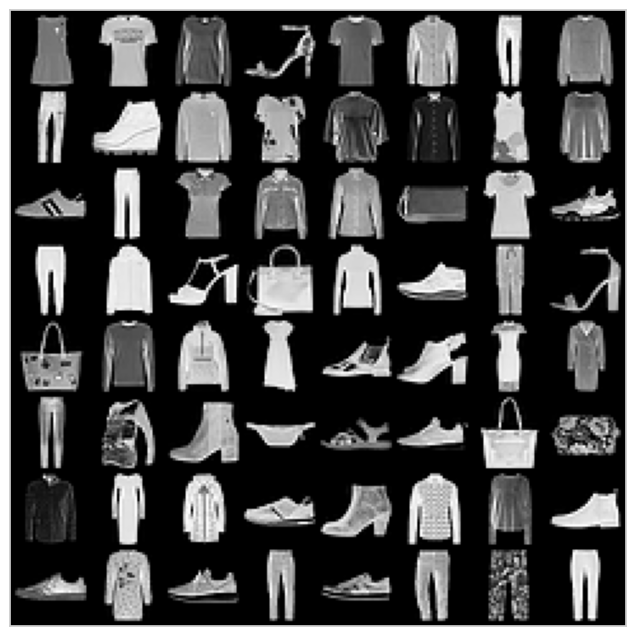

In [38]:
for img, label in train_loader:
    print(img.shape)
    show_images(img)
    break

In [39]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_val,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [40]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [41]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [42]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_func = F.cross_entropy
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=40, gamma=0.1)

loss_history, score_history = train(model, opt, train_loader, val_loader, loss_func, 100, scheduler)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-33-ff99a27b8c7c>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


Train loss: 0.01520823254585266, val loss: 1.7333219248453775


  1%|          | 1/100 [00:04<07:05,  4.30s/it]

Train score: 0.7453999519348145, val score: 0.7434999942779541
Train loss: 0.013558461034297944, val loss: 1.702457985941569


  2%|▏         | 2/100 [00:08<06:37,  4.05s/it]

Train score: 0.7691999673843384, val score: 0.7647333145141602
Train loss: 0.013337010455131531, val loss: 1.6785035217285156


  3%|▎         | 3/100 [00:12<06:26,  3.99s/it]

Train score: 0.7924999594688416, val score: 0.7857999801635742
Train loss: 0.01325548688173294, val loss: 1.6729320579528808


  4%|▍         | 4/100 [00:16<06:47,  4.24s/it]

Train score: 0.7980999946594238, val score: 0.79093337059021
Train loss: 0.01316234210729599, val loss: 1.6621434796651204


  5%|▌         | 5/100 [00:20<06:32,  4.13s/it]

Train score: 0.8090999722480774, val score: 0.8005333542823792
Train loss: 0.013111012542247773, val loss: 1.6483837768554688


  6%|▌         | 6/100 [00:24<06:20,  4.05s/it]

Train score: 0.8301999568939209, val score: 0.8164333701133728
Train loss: 0.01300824853181839, val loss: 1.6410737665812174


  7%|▋         | 7/100 [00:29<06:37,  4.27s/it]

Train score: 0.8392999768257141, val score: 0.8228999972343445
Train loss: 0.012929561126232147, val loss: 1.6287124053955078


  8%|▊         | 8/100 [00:33<06:45,  4.41s/it]

Train score: 0.8497999906539917, val score: 0.8342999815940857
Train loss: 0.012860281145572663, val loss: 1.6328089101155598


  9%|▉         | 9/100 [00:38<06:32,  4.31s/it]

Train score: 0.8504999876022339, val score: 0.8292333483695984
Train loss: 0.012800611805915832, val loss: 1.6300666267395019


 10%|█         | 10/100 [00:42<06:38,  4.43s/it]

Train score: 0.8501999974250793, val score: 0.8315666913986206
Train loss: 0.01279163019657135, val loss: 1.6289208353678386


 11%|█         | 11/100 [00:46<06:23,  4.31s/it]

Train score: 0.8600999712944031, val score: 0.8321666717529297
Train loss: 0.012783603847026825, val loss: 1.638148579152425


 12%|█▏        | 12/100 [00:50<06:10,  4.21s/it]

Train score: 0.8483999967575073, val score: 0.8220999836921692
Train loss: 0.012762122070789337, val loss: 1.6310696703592935


 13%|█▎        | 13/100 [00:55<06:09,  4.25s/it]

Train score: 0.8561999797821045, val score: 0.8301666975021362
Train loss: 0.012698540794849396, val loss: 1.624972934214274


 14%|█▍        | 14/100 [00:59<06:02,  4.22s/it]

Train score: 0.8643999695777893, val score: 0.8364999890327454
Train loss: 0.012702400290966033, val loss: 1.6181998565673827


 15%|█▌        | 15/100 [01:03<05:51,  4.14s/it]

Train score: 0.8661999702453613, val score: 0.8427333235740662
Train loss: 0.012721588039398194, val loss: 1.6145352063496907


 16%|█▌        | 16/100 [01:07<05:45,  4.11s/it]

Train score: 0.871999979019165, val score: 0.8469333648681641
Train loss: 0.012659252488613128, val loss: 1.6252163447062173


 17%|█▋        | 17/100 [01:11<05:52,  4.25s/it]

Train score: 0.8597999811172485, val score: 0.8352000117301941
Train loss: 0.012695748662948609, val loss: 1.6211096356709798


 18%|█▊        | 18/100 [01:15<05:41,  4.17s/it]

Train score: 0.8695999979972839, val score: 0.8396000266075134
Train loss: 0.012647639238834382, val loss: 1.616026412709554


 19%|█▉        | 19/100 [01:19<05:32,  4.11s/it]

Train score: 0.8782999515533447, val score: 0.845633327960968
Train loss: 0.012611295127868653, val loss: 1.6123348940531412


 20%|██        | 20/100 [01:24<05:43,  4.29s/it]

Train score: 0.8805999755859375, val score: 0.848633348941803
Train loss: 0.012591868889331817, val loss: 1.626542621612549


 21%|██        | 21/100 [01:28<05:31,  4.20s/it]

Train score: 0.8623999953269958, val score: 0.8342000246047974
Train loss: 0.012656182193756103, val loss: 1.6076774200439452


 22%|██▏       | 22/100 [01:32<05:22,  4.13s/it]

Train score: 0.8833999633789062, val score: 0.8533999919891357
Train loss: 0.012587492299079895, val loss: 1.6186869898478191


 23%|██▎       | 23/100 [01:37<05:30,  4.29s/it]

Train score: 0.8737999796867371, val score: 0.84170001745224
Train loss: 0.012568051552772522, val loss: 1.608006851196289


 24%|██▍       | 24/100 [01:41<05:21,  4.23s/it]

Train score: 0.8860999941825867, val score: 0.8532000184059143
Train loss: 0.012607045042514801, val loss: 1.6279399676005046


 25%|██▌       | 25/100 [01:45<05:11,  4.15s/it]

Train score: 0.8659999966621399, val score: 0.8328666687011719
Train loss: 0.01259720677137375, val loss: 1.606757209777832


 26%|██▌       | 26/100 [01:49<05:15,  4.26s/it]

Train score: 0.889799952507019, val score: 0.8533999919891357
Train loss: 0.012551523649692536, val loss: 1.6111696131388347


 27%|██▋       | 27/100 [01:53<05:06,  4.20s/it]

Train score: 0.882099986076355, val score: 0.8497000336647034
Train loss: 0.012520147490501404, val loss: 1.6111488471984863


 28%|██▊       | 28/100 [01:57<04:57,  4.13s/it]

Train score: 0.8831999897956848, val score: 0.8497999906539917
Train loss: 0.012513597524166108, val loss: 1.6235136479695638


 29%|██▉       | 29/100 [02:01<04:51,  4.11s/it]

Train score: 0.8744999766349792, val score: 0.8369666934013367
Train loss: 0.012542359590530395, val loss: 1.6189518610636393


 30%|███       | 30/100 [02:06<04:55,  4.22s/it]

Train score: 0.8748999834060669, val score: 0.84170001745224
Train loss: 0.012523973619937897, val loss: 1.6099501055399577


 31%|███       | 31/100 [02:10<04:46,  4.16s/it]

Train score: 0.88919997215271, val score: 0.8508000373840332
Train loss: 0.012508467066287995, val loss: 1.614284910329183


 32%|███▏      | 32/100 [02:14<04:38,  4.09s/it]

Train score: 0.8791999816894531, val score: 0.847000002861023
Train loss: 0.012514243531227112, val loss: 1.6071547437032063


 33%|███▎      | 33/100 [02:18<04:47,  4.29s/it]

Train score: 0.8901000022888184, val score: 0.8540000319480896
Train loss: 0.012530075061321259, val loss: 1.6141063087463379


 34%|███▍      | 34/100 [02:22<04:36,  4.20s/it]

Train score: 0.8827999830245972, val score: 0.846833348274231
Train loss: 0.012519515764713288, val loss: 1.6084747922261555


 35%|███▌      | 35/100 [02:26<04:29,  4.14s/it]

Train score: 0.8867999911308289, val score: 0.8525333404541016
Train loss: 0.012500142955780029, val loss: 1.6050712280273438


 36%|███▌      | 36/100 [02:31<04:40,  4.38s/it]

Train score: 0.8952999711036682, val score: 0.8549667000770569
Train loss: 0.012495537459850312, val loss: 1.6105192776997883


 37%|███▋      | 37/100 [02:36<04:44,  4.52s/it]

Train score: 0.8863999843597412, val score: 0.8498666882514954
Train loss: 0.012497906470298767, val loss: 1.6100799748738608


 38%|███▊      | 38/100 [02:40<04:31,  4.37s/it]

Train score: 0.8888999819755554, val score: 0.8513000011444092
Train loss: 0.012560009622573852, val loss: 1.617728938293457


 39%|███▉      | 39/100 [02:44<04:22,  4.30s/it]

Train score: 0.8754000067710876, val score: 0.8430333137512207
Train loss: 0.012520254695415498, val loss: 1.6131342590332032


 40%|████      | 40/100 [02:49<04:20,  4.34s/it]

Train score: 0.8860999941825867, val score: 0.8479999899864197
Train loss: 0.012437608730793, val loss: 1.6008597958882649


 41%|████      | 41/100 [02:53<04:09,  4.22s/it]

Train score: 0.9001999497413635, val score: 0.8597000241279602
Train loss: 0.012407768571376801, val loss: 1.5994833541870117


 42%|████▏     | 42/100 [02:57<04:00,  4.14s/it]

Train score: 0.9021999835968018, val score: 0.861133337020874
Train loss: 0.01237087287902832, val loss: 1.5995016980489094


 43%|████▎     | 43/100 [03:01<04:05,  4.31s/it]

Train score: 0.9025999903678894, val score: 0.860966682434082
Train loss: 0.01236770601272583, val loss: 1.5985804135640462


 44%|████▍     | 44/100 [03:05<03:55,  4.21s/it]

Train score: 0.9023999571800232, val score: 0.8619666695594788
Train loss: 0.012371844255924224, val loss: 1.59880636622111


 45%|████▌     | 45/100 [03:09<03:47,  4.14s/it]

Train score: 0.9045999646186829, val score: 0.8619333505630493
Train loss: 0.012346452105045319, val loss: 1.598206024424235


 46%|████▌     | 46/100 [03:14<03:54,  4.35s/it]

Train score: 0.9050999879837036, val score: 0.8620666861534119
Train loss: 0.012373390257358551, val loss: 1.5979679285685222


 47%|████▋     | 47/100 [03:18<03:45,  4.25s/it]

Train score: 0.9052000045776367, val score: 0.8625666499137878
Train loss: 0.012369682276248932, val loss: 1.59835238571167


 48%|████▊     | 48/100 [03:22<03:39,  4.22s/it]

Train score: 0.9047999978065491, val score: 0.8620333671569824
Train loss: 0.012328098237514495, val loss: 1.5982482755025227


 49%|████▉     | 49/100 [03:27<03:43,  4.38s/it]

Train score: 0.9045999646186829, val score: 0.8619000315666199
Train loss: 0.01234631130695343, val loss: 1.5978840980529785


 50%|█████     | 50/100 [03:31<03:34,  4.29s/it]

Train score: 0.9062999486923218, val score: 0.8632333278656006
Train loss: 0.012315875053405761, val loss: 1.59799218266805


 51%|█████     | 51/100 [03:35<03:26,  4.21s/it]

Train score: 0.9067999720573425, val score: 0.862166702747345
Train loss: 0.012348711597919464, val loss: 1.5974453252156575


 52%|█████▏    | 52/100 [03:40<03:24,  4.26s/it]

Train score: 0.9060999751091003, val score: 0.8633000254631042
Train loss: 0.01233775464296341, val loss: 1.5967813372294108


 53%|█████▎    | 53/100 [03:44<03:19,  4.24s/it]

Train score: 0.9077000021934509, val score: 0.8637999892234802
Train loss: 0.012330089581012726, val loss: 1.5966185396830241


 54%|█████▍    | 54/100 [03:48<03:10,  4.15s/it]

Train score: 0.9074999690055847, val score: 0.8637999892234802
Train loss: 0.012328511226177216, val loss: 1.5968188545227051


 55%|█████▌    | 55/100 [03:52<03:04,  4.10s/it]

Train score: 0.906499981880188, val score: 0.8636000156402588
Train loss: 0.01235736004114151, val loss: 1.5971223559061687


 56%|█████▌    | 56/100 [03:56<03:07,  4.26s/it]

Train score: 0.9075999855995178, val score: 0.8635333180427551
Train loss: 0.012305399942398071, val loss: 1.596410893758138


 57%|█████▋    | 57/100 [04:00<02:59,  4.17s/it]

Train score: 0.9067999720573425, val score: 0.8644333481788635
Train loss: 0.012302767717838288, val loss: 1.596994125620524


 58%|█████▊    | 58/100 [04:04<02:53,  4.14s/it]

Train score: 0.9086999893188477, val score: 0.8638666868209839
Train loss: 0.012319714999198914, val loss: 1.5955979598999024


 59%|█████▉    | 59/100 [04:10<03:09,  4.61s/it]

Train score: 0.9088999629020691, val score: 0.8652999997138977
Train loss: 0.012304554104804993, val loss: 1.5958630104064941


 60%|██████    | 60/100 [04:14<03:00,  4.52s/it]

Train score: 0.9086999893188477, val score: 0.8648666739463806
Train loss: 0.012295004475116729, val loss: 1.5960732398986817


 61%|██████    | 61/100 [04:18<02:50,  4.36s/it]

Train score: 0.9091999530792236, val score: 0.8648666739463806
Train loss: 0.012287355268001557, val loss: 1.5958442794799805


 62%|██████▏   | 62/100 [04:23<02:50,  4.49s/it]

Train score: 0.910099983215332, val score: 0.8651666641235352
Train loss: 0.012303576624393462, val loss: 1.5964705843607585


 63%|██████▎   | 63/100 [04:27<02:40,  4.34s/it]

Train score: 0.9098999500274658, val score: 0.8636666536331177
Train loss: 0.012312369585037232, val loss: 1.595538602956136


 64%|██████▍   | 64/100 [04:31<02:32,  4.24s/it]

Train score: 0.9113999605178833, val score: 0.8648666739463806
Train loss: 0.012287221038341522, val loss: 1.5949749735514323


 65%|██████▌   | 65/100 [04:36<02:35,  4.43s/it]

Train score: 0.911799967288971, val score: 0.8656666874885559
Train loss: 0.012309593045711517, val loss: 1.5955769200642904


 66%|██████▌   | 66/100 [04:40<02:26,  4.31s/it]

Train score: 0.9121999740600586, val score: 0.865066647529602
Train loss: 0.012308647310733795, val loss: 1.5952335538228353


 67%|██████▋   | 67/100 [04:44<02:18,  4.21s/it]

Train score: 0.9121999740600586, val score: 0.8665000200271606
Train loss: 0.012282453894615174, val loss: 1.5955568186442057


 68%|██████▊   | 68/100 [04:49<02:18,  4.33s/it]

Train score: 0.9089999794960022, val score: 0.8653333187103271
Train loss: 0.012295108246803283, val loss: 1.5956489456176757


 69%|██████▉   | 69/100 [04:53<02:12,  4.26s/it]

Train score: 0.913100004196167, val score: 0.8647333383560181
Train loss: 0.012300214385986328, val loss: 1.5949818031311036


 70%|███████   | 70/100 [04:57<02:05,  4.18s/it]

Train score: 0.9134999513626099, val score: 0.8654333353042603
Train loss: 0.012271296751499176, val loss: 1.5945852966308594


 71%|███████   | 71/100 [05:01<02:01,  4.18s/it]

Train score: 0.913599967956543, val score: 0.8659999966621399
Train loss: 0.01228633680343628, val loss: 1.5943964093526204


 72%|███████▏  | 72/100 [05:05<01:58,  4.24s/it]

Train score: 0.9120000004768372, val score: 0.866433322429657
Train loss: 0.012268919110298157, val loss: 1.5939728747049968


 73%|███████▎  | 73/100 [05:10<01:57,  4.34s/it]

Train score: 0.9136999845504761, val score: 0.8669999837875366
Train loss: 0.012275659716129303, val loss: 1.5948227587381998


 74%|███████▍  | 74/100 [05:18<02:20,  5.40s/it]

Train score: 0.913599967956543, val score: 0.8665333390235901
Train loss: 0.012275802671909333, val loss: 1.5943154006958007


 75%|███████▌  | 75/100 [05:22<02:07,  5.11s/it]

Train score: 0.9152999520301819, val score: 0.8663333654403687
Train loss: 0.012255969774723053, val loss: 1.5942034983317057


 76%|███████▌  | 76/100 [05:26<01:54,  4.77s/it]

Train score: 0.9129999876022339, val score: 0.8665666580200195
Train loss: 0.012253327250480651, val loss: 1.5948361317952473


 77%|███████▋  | 77/100 [05:32<01:58,  5.14s/it]

Train score: 0.9133999943733215, val score: 0.8657000064849854
Train loss: 0.012277990055084228, val loss: 1.594291853841146


 78%|███████▊  | 78/100 [05:37<01:48,  4.95s/it]

Train score: 0.9144999980926514, val score: 0.866433322429657
Train loss: 0.012256025588512421, val loss: 1.5935967656453451


 79%|███████▉  | 79/100 [05:42<01:46,  5.07s/it]

Train score: 0.9165999889373779, val score: 0.8672666549682617
Train loss: 0.01227674947977066, val loss: 1.5938873672485352


 80%|████████  | 80/100 [05:47<01:42,  5.11s/it]

Train score: 0.9161999821662903, val score: 0.8671666979789734
Train loss: 0.012245820116996766, val loss: 1.593950851949056


 81%|████████  | 81/100 [05:51<01:31,  4.82s/it]

Train score: 0.917199969291687, val score: 0.8671000003814697
Train loss: 0.012264317655563354, val loss: 1.593977805074056


 82%|████████▏ | 82/100 [05:56<01:25,  4.73s/it]

Train score: 0.9169999957084656, val score: 0.8673666715621948
Train loss: 0.012249344480037689, val loss: 1.5941183316548666


 83%|████████▎ | 83/100 [06:01<01:22,  4.87s/it]

Train score: 0.9174000024795532, val score: 0.8670666813850403
Train loss: 0.012247667968273163, val loss: 1.5941327743530274


 84%|████████▍ | 84/100 [06:05<01:14,  4.65s/it]

Train score: 0.9178999662399292, val score: 0.8665000200271606
Train loss: 0.012255001902580262, val loss: 1.5939105461120606


 85%|████████▌ | 85/100 [06:11<01:13,  4.89s/it]

Train score: 0.9177999496459961, val score: 0.8669999837875366
Train loss: 0.012247743558883667, val loss: 1.593886710357666


 86%|████████▌ | 86/100 [06:16<01:08,  4.88s/it]

Train score: 0.9180999994277954, val score: 0.8672000169754028
Train loss: 0.012244824981689453, val loss: 1.5938672465006511


 87%|████████▋ | 87/100 [06:20<01:00,  4.68s/it]

Train score: 0.9185999631881714, val score: 0.8669999837875366
Train loss: 0.012247224605083465, val loss: 1.593693623606364


 88%|████████▊ | 88/100 [06:24<00:54,  4.52s/it]

Train score: 0.9182999730110168, val score: 0.8668333292007446
Train loss: 0.012240429973602295, val loss: 1.5936164558410644


 89%|████████▉ | 89/100 [06:29<00:50,  4.63s/it]

Train score: 0.9178999662399292, val score: 0.8672000169754028
Train loss: 0.012242659533023835, val loss: 1.5937940010070801


 90%|█████████ | 90/100 [06:33<00:46,  4.61s/it]

Train score: 0.9180999994277954, val score: 0.8668000102043152
Train loss: 0.012246608066558837, val loss: 1.5936681368509928


 91%|█████████ | 91/100 [06:38<00:40,  4.47s/it]

Train score: 0.91839998960495, val score: 0.8673999905586243
Train loss: 0.012240277433395386, val loss: 1.5937138313293457


 92%|█████████▏| 92/100 [06:42<00:36,  4.60s/it]

Train score: 0.9182999730110168, val score: 0.8666333556175232
Train loss: 0.012234739756584168, val loss: 1.5935675821940105


 93%|█████████▎| 93/100 [06:46<00:31,  4.43s/it]

Train score: 0.9181999564170837, val score: 0.8672000169754028
Train loss: 0.012239833116531372, val loss: 1.5934390907287597


 94%|█████████▍| 94/100 [06:50<00:25,  4.29s/it]

Train score: 0.9176999926567078, val score: 0.8675000071525574
Train loss: 0.012239316427707671, val loss: 1.5934881553649902


 95%|█████████▌| 95/100 [06:56<00:24,  4.83s/it]

Train score: 0.9172999858856201, val score: 0.8673999905586243
Train loss: 0.012246371138095855, val loss: 1.5935345809936523


 96%|█████████▌| 96/100 [07:00<00:18,  4.58s/it]

Train score: 0.9179999828338623, val score: 0.8673666715621948
Train loss: 0.012256561315059662, val loss: 1.5934584569295247


 97%|█████████▋| 97/100 [07:04<00:13,  4.41s/it]

Train score: 0.9179999828338623, val score: 0.8674666881561279
Train loss: 0.012247602868080139, val loss: 1.5934024358113608


 98%|█████████▊| 98/100 [07:09<00:09,  4.52s/it]

Train score: 0.9178999662399292, val score: 0.8675333261489868
Train loss: 0.012239899849891663, val loss: 1.593370420074463


 99%|█████████▉| 99/100 [07:14<00:04,  4.47s/it]

Train score: 0.9178999662399292, val score: 0.8673999905586243
Train loss: 0.01222942988872528, val loss: 1.59348554204305


100%|██████████| 100/100 [07:18<00:00,  4.38s/it]

Train score: 0.9185999631881714, val score: 0.8673000335693359


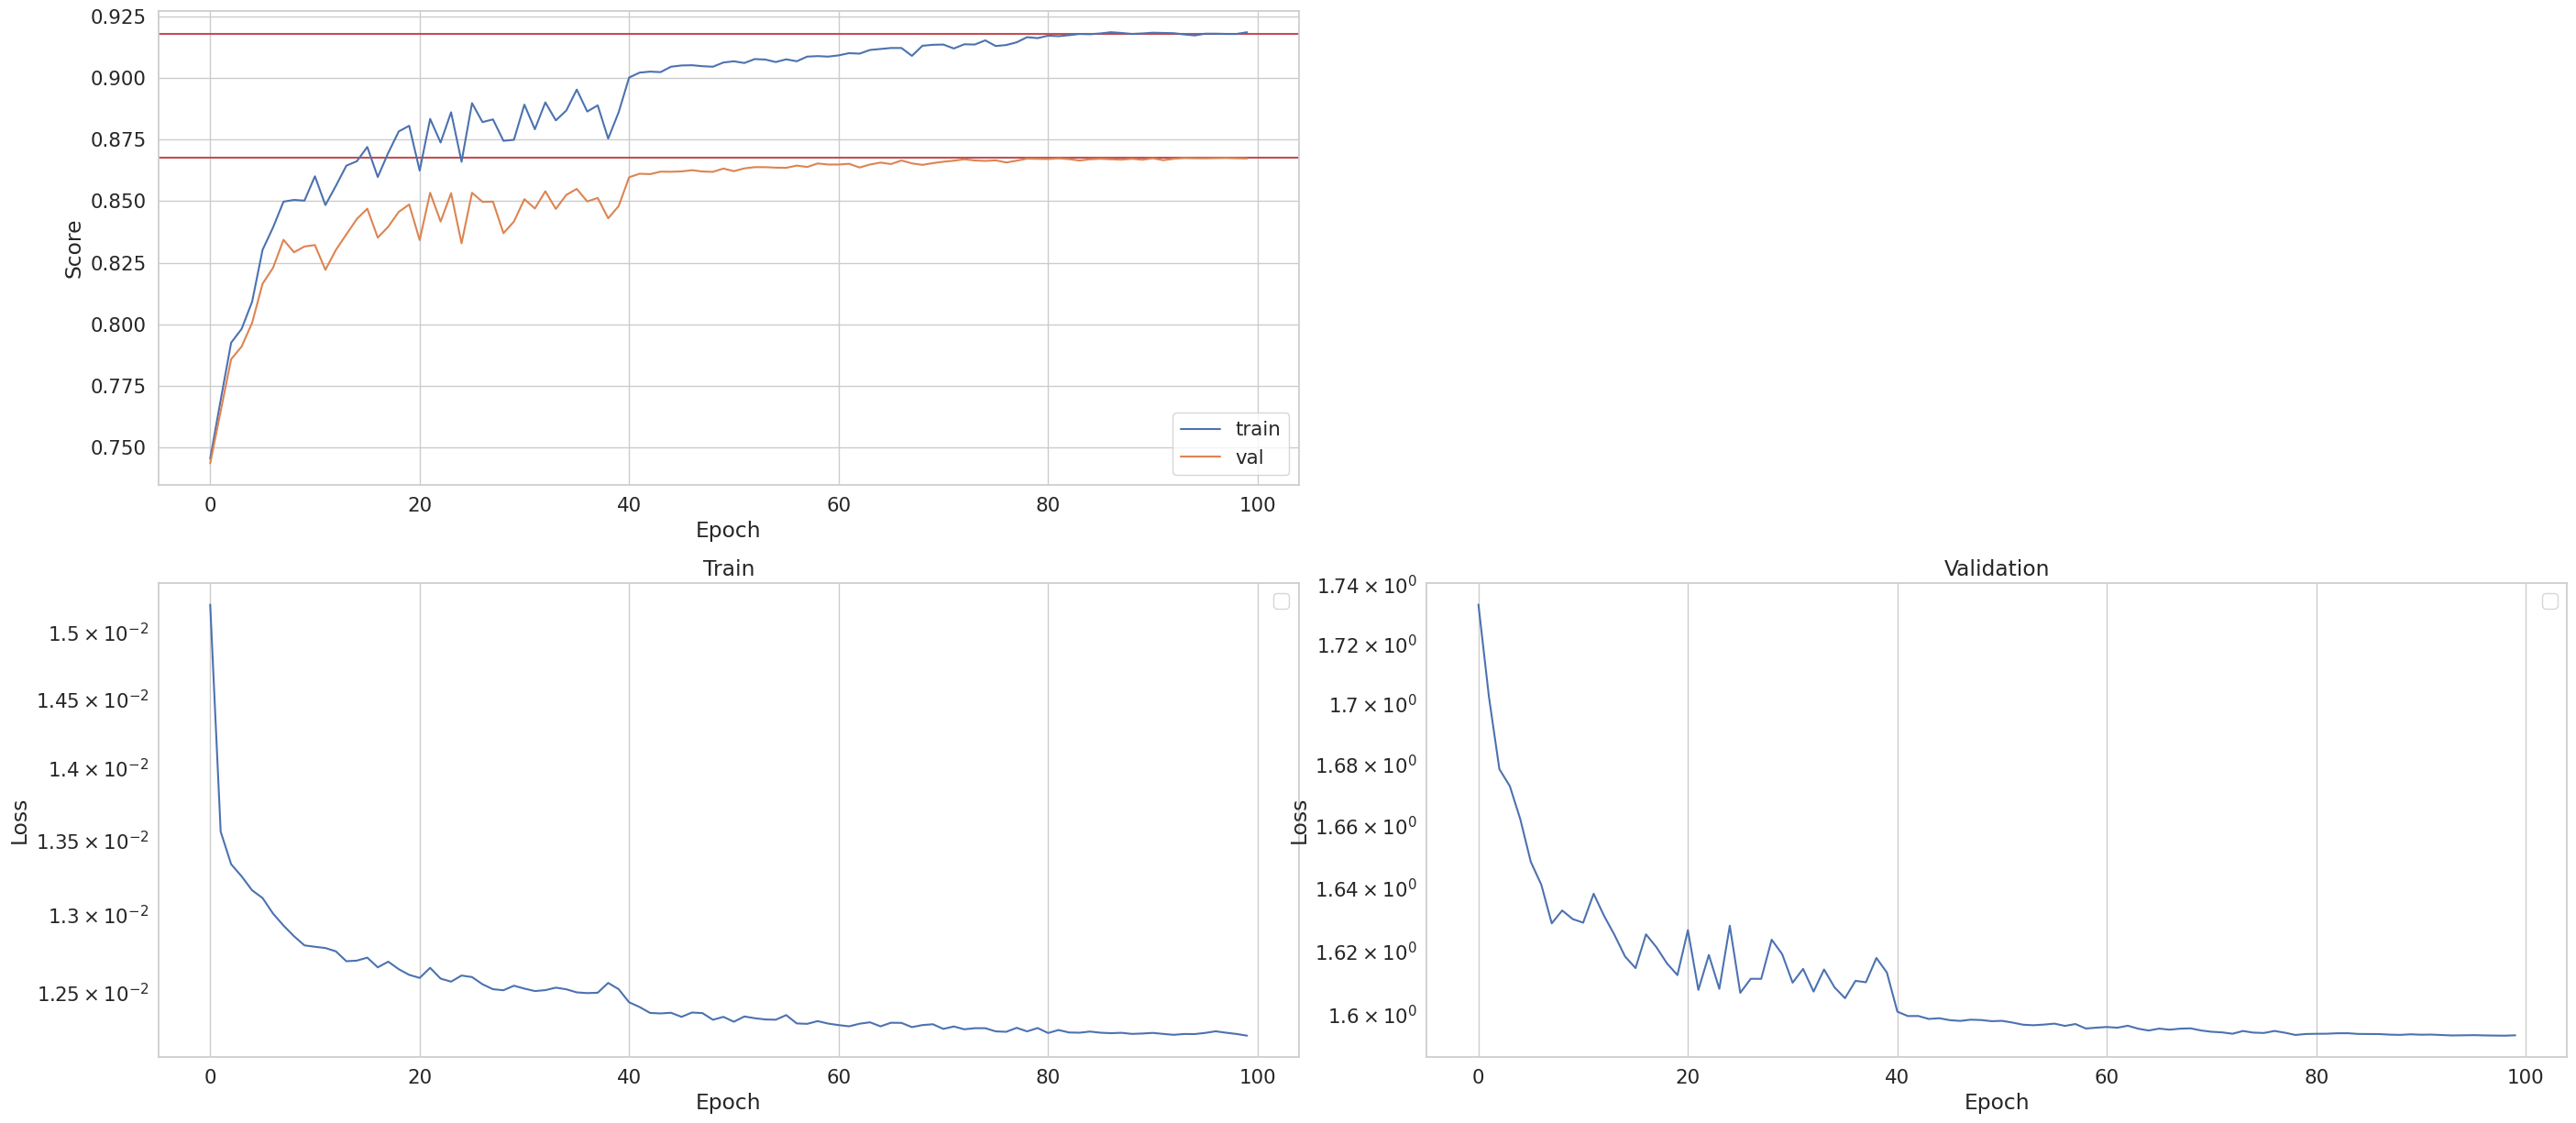

In [43]:
handle_history(loss_history, score_history)

Действительно, с использованием дропаута рост скора не трейне и валидации прекращается примерно в один момент.

In [44]:
accuracy = get_accuracy_score(model, test_loader)
print(f"accuracy: {accuracy}")

<ipython-input-33-ff99a27b8c7c>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


accuracy: 0.8600999712944031


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

См. решения предыдущих пунктов.

### Conclusions:



### Общие слова
Рассмотрены архитектуры, которые подвержены риску переобучения. В ходе работы изучены различные техники регуляризации, такие как дропаут, батчнорм. На практике доказана их эффективность. Для получения скора выше порога 0.885 я использовал технику lr-decay с применением степ-шедулера. Стоит отметить, что также можно было и аугментировать изображения.

### Сравнение графиков
С использованием техники lr-decay график скора получается более "гладким" и, как следствие, делать выводы о переобучении модели становится проще.

P.S. С добавлением регуляризации модель действительно склонна терять своё качество, поскольку есть некоторый trade-off между стабильностью и качеством модели.